In [2]:
import pandapower as pp

import pandas as pd
import numpy as np
from numpy.random import default_rng
import cvxpy as cp
import networkx as nx
import mosek

from solution_files_manager import SolutionFilesManager
from opt_utils import *
from opf_utils import *

In [3]:
import os
folder = os.path.abspath(os.getcwd())

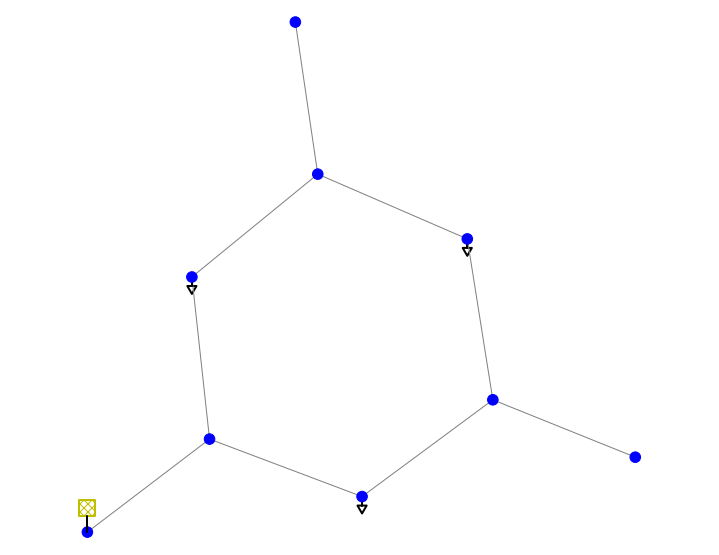

In [4]:
case = "case9"
net, n, gen_df, n_gen, gens, load_df, graph, G_val, B_val, Y_val = load_pp_network(case)

## Parameters

In [23]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [24]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [25]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

In [26]:
Phis = []
Psis = []
for i in range(n):
    J_i = np.zeros((n,n))
    J_i[i][i] = 1
    Y_i = J_i @ Y_val
    Phi_i = 1 / 2 * (Y_i.conj().T + Y_i)
    Phis.append(Phi_i)
    Psi_i = 1 / 2j * (Y_i.conj().T - Y_i)
    Psis.append(Psi_i)

### Build sparsity graph

In [27]:
sparsity_graph = nx.Graph()
graph_nodes_list = sorted(graph.nodes())
# the sparsity graph of complex variables is exactly the power network
sparsity_graph.add_nodes_from(graph_nodes_list)
sparsity_graph.add_edges_from(graph.edges())

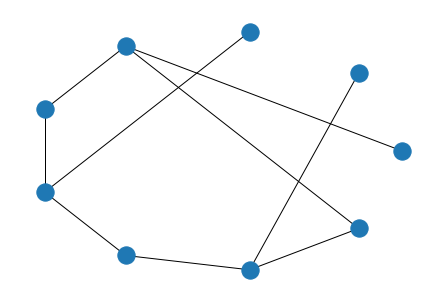

In [28]:
nx.draw(sparsity_graph, nx.circular_layout(sparsity_graph))

## TODO: edge elimination

In [29]:
# edge_elimination_list = list(sparsity_graph.edges)
# sparsity_graph.remove_edges_from(edge_elimination_list)

In [30]:
# for e in edge_elimination_list:
#     sparsity_graph.add_node((e,1))
#     sparsity_graph.add_node((e,2))
#
# sparsity_graph.add_node("one")
#
# for e in edge_elimination_list:
#     sparsity_graph.add_edge((e,1), "one")
#     sparsity_graph.add_edge((e,2), "one")
#     sparsity_graph.add_edge(e[0], "one")
#     sparsity_graph.add_edge(e[1], "one")

In [31]:
# nx.set_edge_attributes(sparsity_graph, 0, "weight")
# n_sparse = sparsity_graph.number_of_nodes()
#
# for i in range(n):
#     Phi_i = Phis[i].value
#     graph_phi_i = sparsity_graph.copy()
#     graph_phi_i.add_edge(i, i, weight=Phi_i[i][i])
#
#     Psi_i = Psis[i].value
#     graph_psi_i = sparsity_graph.copy()
#     graph_psi_i.add_edge(i, i, weight=Psi_i[i][i])
#
#     for j in graph.neighbors(i):  # quadratic terms only appear for adjacent buses
#         if (i,j) in edge_elimination_list:
#             # replace variables in the constraints of bus i
#             graph_phi_i.edges[(((i, j), 1), ((i, j), 1))]["weight"] = Phi_i[i][j]
#             graph_phi_i.edges[(((i, j), 2), ((i, j), 2))]["weight"] = -Phi_i[i][j]
#
#             # TODO: graph_psi_i
#
#             # impose linear constraints on the new variables
#             linear_constraint_mat = np.zeros(n_sparse)
#             # TODO
#
#
#         else:
#             # don't replace variables in the constraints of bus i
#             graph_phi_i.edges[(i, j)]["weight"] = G_val[i][j]
#             graph_phi_i.edges[(n + i, n + j)]["weight"] = G_val[i][j]
#             graph_phi_i.edges[(i, n + j)]["weight"] = -B_val[i][j]
#             graph_phi_i.edges[(n + i, j)]["weight"] = B_val[i][j]
#
#             # TODO

### Construct enriched supergraph

In [32]:
G_bar = build_enriched_supergraph(sparsity_graph)

Treewidth: 2


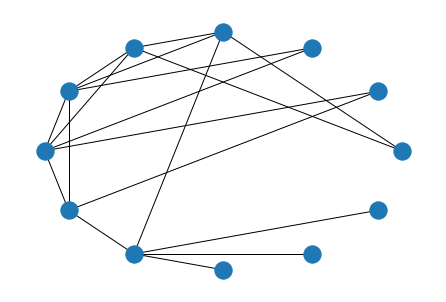

In [33]:
nx.draw(G_bar, nx.circular_layout(G_bar))

## SDP (QCQP)

In [34]:
treewidth, tree_decomp = nx.algorithms.approximation.treewidth_min_degree(sparsity_graph)

In [ ]:
X = []
for bag in tree_decomp.nodes:
    X_i_size = len(bag)
    X.append(cp.Variable((X_i_size, X_i_size), hermitian=True))

In [ ]:
constraints = [ X[i] >> 0 for i in range(len(X)) ]

for i in range(n):
    # TODO: multiple generators at one bus
    if i in gens:
        i_gen_idx = list(gens).index(i)
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] <= p_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] >= p_min[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] <= q_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] >= q_min[i_gen_idx] ]
    else:
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) == -p_d[i] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) == -q_d[i] ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [ ]:
# the power generation costs are not dpp but can be modified
p_cost = cp.sum([ c_p_2[i] * cp.square((cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]])) + c_p_1[i] * (cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_p_0)
q_cost = cp.sum([ c_q_2[i] * cp.square((cp.real(cp.trace(Psis[gens[i]] @ X)) + p_d[gens[i]])) + c_q_1[i] * (cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_q_0)

loss_cost = cp.sum([ cp.sum([ G[i][j] * cp.real(X[i][i] + X[j][j] - X[i][j] - X[j][i]) for j in range(i)]) for i in range(n)])

In [ ]:
# power generation cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# line loss
# prob = cp.Problem(cp.Minimize(loss_cost), constraints)

In [ ]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# X.value = sfm.load_solution()[1]
# X_ref_val = X.value

In [ ]:
# prob.solve(solver=cp.SCS, verbose=True)
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, verbose=True)

In [283]:
np.linalg.eigvalsh(X.value)

array([-5.57105193e-10, -5.48046223e-10, -5.44674062e-10, -5.42610822e-10,
       -5.33387780e-10, -5.30961843e-10, -5.20112720e-10, -5.18272119e-10,
       -5.13575227e-10, -5.08685229e-10, -5.04442607e-10, -5.02853657e-10,
       -5.01133095e-10, -4.97512219e-10, -4.60968024e-10, -4.25543840e-10,
       -4.11212305e-10, -3.99528857e-10, -3.72031873e-10, -3.26389539e-10,
       -2.91344059e-10, -2.15925591e-10,  8.43635486e-12,  2.49464150e-10,
        4.44052016e-10,  6.02763417e-10,  7.27080722e-10,  1.67374641e-09,
        2.43471914e-09,  7.76429390e-09,  5.52229901e-08,  1.07815098e-07,
        2.97152091e+01])

In [284]:
X_ref_val = X.value

In [285]:
recover_verify_solution(prob, X, 1)

6.3415981998256135e-15
[0.]
[0.]
[0.]
[0.]
[1.25377122e-07]
[7.75807718e-08]
[4.4870507e-08]
[2.35165838e-08]
[3.55926377e-08]
[1.70245356e-08]
[2.03355694e-08]
[1.36100161e-08]
[3.26648719e-08]
[4.09147873e-08]
[1.16659873e-08]
[1.44326966e-08]
[1.64162199e-08]
[6.30961571e-09]
[9.70130264e-09]
[3.64974073e-09]
[4.05992357e-08]
[9.52278545e-09]
[4.85472887e-08]
[1.25879181e-08]
[1.52839694e-08]
[1.46660841e-08]
[1.06537689e-09]
[4.71791289e-09]
[4.1184287e-09]
[5.99073945e-09]
[1.72804355e-08]
[1.01959415e-08]
[2.56682448e-10]
[3.27083582e-09]
[4.59942861e-09]
[8.64167293e-09]
[8.27758341e-09]
[9.71521971e-10]
[3.06507243e-08]
[3.07551802e-08]
[7.74131836e-09]
[1.18339547e-08]
[9.81964165e-09]
[1.15388112e-08]
[7.49221471e-10]
[1.6058137e-09]
[1.59388677e-08]
[1.58856867e-08]
[4.4138055e-09]
[5.45216626e-09]
[1.60938637e-10]
[8.4238792e-10]
[3.64030332e-08]
[4.74701572e-09]
[1.75497374e-08]
[1.14292438e-08]
[1.19805106e-08]
[4.58963378e-09]
[2.07664237e-08]
[8.72133509e-09]
[1.3177499

In [286]:
recover_verify_solution(prob, X, 2)

7.763394859438281e-15
[0.]
[0.]
[0.]
[0.]
[1.2956958e-07]
[8.94165131e-08]
[4.65441016e-08]
[2.8739215e-08]
[3.62777643e-08]
[1.91332559e-08]
[2.27234069e-08]
[1.33987167e-08]
[3.3637163e-08]
[4.03834204e-08]
[9.49181754e-09]
[1.59696787e-08]
[1.66359872e-08]
[6.68820176e-09]
[1.03239095e-08]
[3.86983978e-09]
[4.29675102e-08]
[7.96759214e-09]
[4.51716103e-08]
[3.68851427e-09]
[1.92273271e-08]
[2.51749725e-08]
[6.17848772e-09]
[3.76447689e-09]
[1.06220299e-08]
[9.6661985e-09]
[1.41581979e-08]
[5.01890585e-09]
[4.34680913e-09]
[9.2197332e-09]
[2.75238676e-09]
[2.51287635e-09]
[2.70082746e-09]
[6.27516661e-09]
[3.13769238e-08]
[3.056565e-08]
[1.10956823e-08]
[1.25764417e-08]
[1.32784482e-08]
[1.52909814e-08]
[3.22537518e-09]
[2.96211455e-09]
[1.80520395e-08]
[1.23546836e-08]
[1.03484956e-08]
[7.44986515e-09]
[4.21334186e-09]
[2.57362085e-09]
[4.34590388e-08]
[1.38725054e-08]
[1.98527912e-08]
[1.2800618e-08]
[1.08724645e-08]
[5.24504107e-09]
[2.00895074e-08]
[9.58835799e-09]
[1.32139428e-0

### Interior point computation

In [302]:
X_ac = cp.Variable((n,n), hermitian=True)

In [303]:
prob_ac = cp.Problem(cp.Maximize(cp.log_det(X_ac) \
                              + cp.sum([ cp.log(p_max[i] - cp.real(cp.trace(Phis[i] @ X_ac)) - p_d[gens[i]]) + cp.log(cp.real(cp.trace(Phis[i] @ X_ac)) + p_d[gens[i]] - p_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(q_max[i] - cp.real(cp.trace(Psis[i] @ X_ac)) - q_d[gens[i]]) + cp.log(cp.real(cp.trace(Psis[i] @ X_ac)) + q_d[gens[i]] - q_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(V_max_sq[i] - cp.real(X_ac[i][i])) + cp.log(cp.real(X_ac[i][i]) - V_min_sq[i]) for i in range(n) ]) ))

# prob_ac.solve(solver=cp.SCS, verbose=True)
prob_ac.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jun 28 11:30:31 AM: Your problem has 1089 variables, 71 constraints, and 142 parameters.
(CVXPY) Jun 28 11:30:31 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 28 11:30:31 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 28 11:30:31 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 28 11:30:31 AM: Reduction chain: EvalParams -> Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jun 28 11:30:31 AM: Applying reduction EvalParams
(CVXPY) Jun 28 11:30:31 AM: App

78.3534104515411

### Fixed point iterations

In [298]:
fixed_point_iteration(prob, X, -X_ac.value, True)

TypeError: bad operand type for unary -: 'NoneType'

In [299]:
recover_verify_solution(prob, X, 1)

6.3415981998256135e-15
[0.]
[0.]
[0.]
[0.]
[1.25377122e-07]
[7.75807718e-08]
[4.4870507e-08]
[2.35165838e-08]
[3.55926377e-08]
[1.70245356e-08]
[2.03355694e-08]
[1.36100161e-08]
[3.26648719e-08]
[4.09147873e-08]
[1.16659873e-08]
[1.44326966e-08]
[1.64162199e-08]
[6.30961571e-09]
[9.70130264e-09]
[3.64974073e-09]
[4.05992357e-08]
[9.52278545e-09]
[4.85472887e-08]
[1.25879181e-08]
[1.52839694e-08]
[1.46660841e-08]
[1.06537689e-09]
[4.71791289e-09]
[4.1184287e-09]
[5.99073945e-09]
[1.72804355e-08]
[1.01959415e-08]
[2.56682448e-10]
[3.27083582e-09]
[4.59942861e-09]
[8.64167293e-09]
[8.27758341e-09]
[9.71521971e-10]
[3.06507243e-08]
[3.07551802e-08]
[7.74131836e-09]
[1.18339547e-08]
[9.81964165e-09]
[1.15388112e-08]
[7.49221471e-10]
[1.6058137e-09]
[1.59388677e-08]
[1.58856867e-08]
[4.4138055e-09]
[5.45216626e-09]
[1.60938637e-10]
[8.4238792e-10]
[3.64030332e-08]
[4.74701572e-09]
[1.75497374e-08]
[1.14292438e-08]
[1.19805106e-08]
[4.58963378e-09]
[2.07664237e-08]
[8.72133509e-09]
[1.3177499

In [ ]:
recover_verify_solution(prob, X, 2)

## Low-rank SDP

In [287]:
n_bar = G_bar.number_of_nodes()
X_bar = cp.Variable((n_bar, n_bar), hermitian=True)
X_ref = cp.Parameter((n, n), hermitian=True, value=X_ref_val)
Z = cp.Parameter((n_bar, n_bar), symmetric=True, value=nx.to_numpy_array(G_bar))

low_rank_constraints = [ X_bar >> 0 ]
low_rank_constraints += [ X_bar[k][k] == X_ref[k][k] for k in sparsity_graph.nodes ]
low_rank_constraints += [ X_bar[k][k] == 1 for k in set(G_bar.nodes).difference(set(sparsity_graph.nodes)) ]
low_rank_constraints += [ X_bar[i][j] == X_ref[i][j] for (i,j) in sparsity_graph.edges ]

low_rank_prob = cp.Problem(cp.Minimize(cp.real(cp.trace(Z @ X_bar))), low_rank_constraints)

In [288]:
# X_bar.value = np.block([
#     [X_ref_val, np.zeros((n, n_bar - n))],
#     [np.zeros((n_bar - n, n)), np.eye(n_bar-n)]
# ])
#
# for c in low_rank_prob.constraints:
#     print(c.violation())

In [289]:
# low_rank_prob.solve(solver=cp.SCS, verbose=True)
low_rank_prob.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jun 28 11:29:00 AM: Your problem has 1089 variables, 66 constraints, and 2178 parameters.
(CVXPY) Jun 28 11:29:00 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 28 11:29:00 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 28 11:29:00 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 28 11:29:00 AM: Reduction chain: EvalParams -> Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jun 28 11:29:00 AM: Applying reduction EvalParams
(CVXPY) Jun 28 11:29:00 AM: Ap

113.60199336820668

In [290]:
X.value = X_bar.value[0:n, 0:n]
print(np.linalg.eigvalsh(X.value))
print(prob.objective.value)

[-1.27429297e-09 -1.26433734e-09 -1.26029581e-09 -1.25331476e-09
 -1.24283428e-09 -1.22739231e-09 -1.22276337e-09 -1.21136792e-09
 -1.19609353e-09 -1.17515548e-09 -1.16591268e-09 -1.14464994e-09
 -1.12240207e-09 -1.05436910e-09 -1.04535003e-09 -9.88908885e-10
 -9.53243956e-10 -8.26233671e-10 -5.37688068e-10 -3.63647448e-10
 -2.07757412e-11  2.29309782e-10  1.85212549e-09  2.86940730e-09
  5.10810939e-09  7.79401645e-09  1.45117495e-08  1.95337216e-08
  2.77847683e-08  6.93118507e-08  1.83755060e-07  4.86350082e-07
  2.97152084e+01]
78.35341424670332


In [291]:
for c in prob.constraints:
    print(c.violation())

1.2742009918958203e-09
[0.]
[0.]
[0.]
[0.]
[7.15427169e-08]
[4.50388879e-08]
[4.42349851e-08]
[2.45220213e-08]
[3.046264e-08]
[1.54578794e-08]
[1.55843585e-08]
[9.12513431e-09]
[3.33017935e-08]
[2.45000262e-08]
[6.95121736e-09]
[6.9694137e-09]
[8.57739433e-09]
[3.89890763e-09]
[5.64194535e-09]
[3.95591537e-09]
[2.57255015e-08]
[9.56628843e-09]
[3.4665536e-08]
[1.14327142e-08]
[1.16767651e-08]
[4.50815002e-09]
[3.66666941e-09]
[4.03261219e-09]
[6.02173643e-09]
[6.32537932e-09]
[7.51312056e-09]
[6.04227301e-09]
[5.52283996e-09]
[4.85970886e-09]
[7.44397832e-09]
[6.72325284e-09]
[4.7807781e-09]
[3.70373731e-09]
[1.80080267e-08]
[1.69703314e-08]
[8.66763871e-09]
[9.45945233e-09]
[9.90809534e-09]
[1.1854969e-08]
[2.11077344e-09]
[2.61831401e-09]
[1.39765973e-08]
[9.93393911e-09]
[9.89781164e-09]
[7.6696751e-09]
[4.24902176e-09]
[3.21717984e-09]
[3.92235788e-08]
[1.99177799e-08]
[1.60915652e-08]
[9.06387726e-09]
[5.68570146e-09]
[4.88455343e-09]
[1.04455053e-08]
[6.41594011e-09]
[9.32169984e

In [292]:
recover_verify_solution(prob, X, 1)

6.8272586921775865e-15
[0.]
[0.]
[0.]
[0.]
[2.02266344e-07]
[1.61479953e-07]
[4.3913683e-08]
[2.72468985e-08]
[5.50639103e-08]
[2.80356849e-08]
[6.28842256e-08]
[3.26467741e-08]
[1.575333e-07]
[3.98098667e-08]
[1.15836021e-08]
[2.76469658e-08]
[2.91955699e-08]
[1.58745135e-08]
[2.64307818e-08]
[1.85706435e-08]
[3.72328273e-07]
[1.09411114e-07]
[5.85595893e-08]
[1.90638546e-08]
[1.9543588e-07]
[4.28312801e-08]
[1.44209821e-09]
[2.89191637e-08]
[2.96384815e-08]
[4.79162239e-08]
[7.71133115e-08]
[5.81055234e-08]
[3.88579975e-08]
[6.55357524e-09]
[2.73191851e-08]
[3.07523229e-09]
[7.4249146e-08]
[5.79913357e-08]
[8.33794264e-08]
[7.89846673e-08]
[4.57252373e-08]
[5.50960375e-08]
[6.07854013e-08]
[6.9797077e-08]
[1.39272599e-08]
[1.81329107e-08]
[2.74863931e-08]
[2.11612575e-08]
[1.28881636e-08]
[9.96111503e-09]
[2.80166665e-08]
[2.16875784e-08]
[1.56349562e-08]
[7.39513922e-09]
[5.86780689e-08]
[2.11376334e-08]
[1.80013717e-08]
[1.50954629e-08]
[2.27285759e-08]
[1.48338908e-09]
[5.91211786

In [293]:
recover_verify_solution(prob, X, 2)

5.632297279427208e-15
[0.]
[0.]
[0.]
[0.]
[3.48708818e-07]
[2.30839852e-07]
[8.81498924e-08]
[5.13443061e-08]
[5.9814695e-08]
[3.03337044e-08]
[3.25506695e-08]
[2.13743155e-08]
[1.32469056e-07]
[6.414325e-08]
[1.78967987e-08]
[1.88035669e-08]
[3.75674989e-08]
[1.47499357e-08]
[2.54108297e-08]
[1.80519411e-08]
[1.15747355e-07]
[4.21996067e-08]
[1.26996919e-07]
[4.20423819e-08]
[4.58886797e-08]
[1.38682747e-08]
[7.04899139e-09]
[3.61984104e-09]
[2.33580137e-08]
[2.55360533e-08]
[2.22477323e-08]
[1.60464385e-08]
[9.22619087e-10]
[6.05968808e-09]
[3.22051519e-08]
[2.41189178e-08]
[2.63996483e-10]
[1.41835429e-10]
[6.41720813e-08]
[6.1049755e-08]
[2.19309339e-08]
[2.54998613e-08]
[4.52640535e-08]
[5.32648241e-08]
[5.504584e-09]
[7.053361e-09]
[1.03004373e-08]
[6.62948974e-09]
[7.97885509e-09]
[6.12318328e-09]
[1.61806428e-08]
[1.24971842e-08]
[3.19898239e-08]
[1.60281429e-08]
[4.04737686e-08]
[1.27585315e-08]
[1.83910405e-08]
[1.55192048e-08]
[2.38200557e-08]
[3.18317542e-11]
[5.42600978e-0

### Low-rank SDP - fixed point iteration

In [294]:
fixed_point_iteration(prob, X, -X_ac.value, True)

TypeError: bad operand type for unary -: 'NoneType'

In [295]:
recover_verify_solution(prob, X, 1)

6.8272586921775865e-15
[0.]
[0.]
[0.]
[0.]
[2.02266344e-07]
[1.61479953e-07]
[4.3913683e-08]
[2.72468985e-08]
[5.50639103e-08]
[2.80356849e-08]
[6.28842256e-08]
[3.26467741e-08]
[1.575333e-07]
[3.98098667e-08]
[1.15836021e-08]
[2.76469658e-08]
[2.91955699e-08]
[1.58745135e-08]
[2.64307818e-08]
[1.85706435e-08]
[3.72328273e-07]
[1.09411114e-07]
[5.85595893e-08]
[1.90638546e-08]
[1.9543588e-07]
[4.28312801e-08]
[1.44209821e-09]
[2.89191637e-08]
[2.96384815e-08]
[4.79162239e-08]
[7.71133115e-08]
[5.81055234e-08]
[3.88579975e-08]
[6.55357524e-09]
[2.73191851e-08]
[3.07523229e-09]
[7.4249146e-08]
[5.79913357e-08]
[8.33794264e-08]
[7.89846673e-08]
[4.57252373e-08]
[5.50960375e-08]
[6.07854013e-08]
[6.9797077e-08]
[1.39272599e-08]
[1.81329107e-08]
[2.74863931e-08]
[2.11612575e-08]
[1.28881636e-08]
[9.96111503e-09]
[2.80166665e-08]
[2.16875784e-08]
[1.56349562e-08]
[7.39513922e-09]
[5.86780689e-08]
[2.11376334e-08]
[1.80013717e-08]
[1.50954629e-08]
[2.27285759e-08]
[1.48338908e-09]
[5.91211786

In [ ]:
recover_verify_solution(prob, X, 2)

### Hyperplane rounding

In [ ]:
def cost_from_exact_solution(v):
    X_exact = np.outer(v, v.conj())
    p_g, q_g = compute_generation(X_exact, n_gen, p_d_val, q_d_val, G_val, B_val, graph)
    p_cost = np.sum(c_p_2.value @ np.square(p_g) + c_p_1.value @ p_g + np.sum(c_p_0.value))
    q_cost = np.sum(c_q_2.value @ np.square(q_g) + c_q_1.value @ q_g + np.sum(c_q_0.value))
    return p_cost + q_cost

In [ ]:
# note that this usually results in an infeasible point
hyperplane_cost, hyperplane_v = complex_hyperplane_rounding(decompose_psd(X.value), cost_from_exact_solution, net.bus["min_vm_pu"].to_numpy(), net.bus["max_vm_pu"].to_numpy())
print(hyperplane_cost)

In [ ]:
check_power_feasibility(np.outer(hyperplane_v, hyperplane_v.conj()), p_min.value, p_max.value, q_min.value, q_max.value, gens, n_gen, p_d_val, q_d_val, G_val, B_val, graph)

In [ ]:
# sfm = SolutionFilesManager(folder, case, "orig")
# a = sfm.load_solution()
# v = a[1]
# X_val = np.outer(v, v.conj())
# X.value = X_val
#
# for c in prob.constraints:
#     print(c.violation())

In [ ]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# sfm.save_solution(prob.value, X.value, None, None)